In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from data_utils import load_images
import torch

In [2]:
train_dataset = load_images("train", percent=1)
test_dataset = load_images("test", percent=1)
validation_dataset = load_images("validation")

In [3]:
from neural_network import get_dataloader_from_image_dataset


# We get the data in the form of a PyTorch dataset

train_loader = get_dataloader_from_image_dataset(train_dataset, batch_size=64)
test_loader = get_dataloader_from_image_dataset(
    test_dataset, batch_size=64, is_test=True
)
validation_loader = get_dataloader_from_image_dataset(validation_dataset, batch_size=64, is_test=True)

In [4]:
print(train_dataset.images.shape)

(12500, 100, 100, 3)


In [5]:
from neural_network import NeuralNetwork

model = NeuralNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

NUM_EPOCHS = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



--- Training with Learning Rate: 0.1 ---
Epoch 1/10, LR: 0.1, Avg Loss: 1.2262
Epoch 2/10, LR: 0.1, Avg Loss: 0.9220
Epoch 3/10, LR: 0.1, Avg Loss: 0.8709
Epoch 4/10, LR: 0.1, Avg Loss: 0.8241
Epoch 5/10, LR: 0.1, Avg Loss: 0.8127
Epoch 6/10, LR: 0.1, Avg Loss: 0.7817
Epoch 7/10, LR: 0.1, Avg Loss: 0.7308
Epoch 8/10, LR: 0.1, Avg Loss: 0.7133
Epoch 9/10, LR: 0.1, Avg Loss: 0.6873
Epoch 10/10, LR: 0.1, Avg Loss: 0.6829
LR: 0.1 -> Validation Accuracy: 74.80%, Avg Validation Loss: 0.9137

--- Training with Learning Rate: 0.01 ---
Epoch 1/10, LR: 0.01, Avg Loss: 0.8305
Epoch 2/10, LR: 0.01, Avg Loss: 0.6265
Epoch 3/10, LR: 0.01, Avg Loss: 0.5359
Epoch 4/10, LR: 0.01, Avg Loss: 0.4692
Epoch 5/10, LR: 0.01, Avg Loss: 0.4141
Epoch 6/10, LR: 0.01, Avg Loss: 0.3557
Epoch 7/10, LR: 0.01, Avg Loss: 0.2804
Epoch 8/10, LR: 0.01, Avg Loss: 0.2532
Epoch 9/10, LR: 0.01, Avg Loss: 0.2319
Epoch 10/10, LR: 0.01, Avg Loss: 0.1875
LR: 0.01 -> Validation Accuracy: 76.08%, Avg Validation Loss: 0.9179

--- T

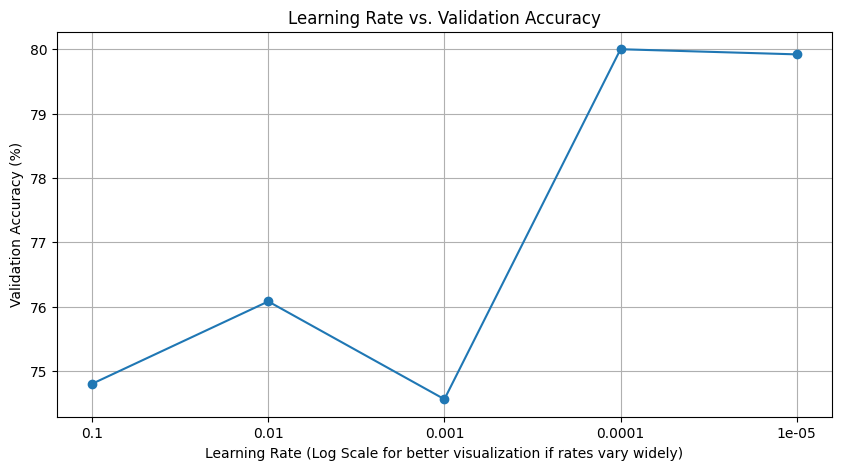

In [ ]:
import torch
import torch.nn as nn
from neural_network import NeuralNetwork # Ensure NeuralNetwork is imported
from data_utils import load_images # Ensure load_images is imported
from neural_network import get_dataloader_from_image_dataset # Ensure get_dataloader_from_image_dataset is imported
import matplotlib.pyplot as plt

# Define the learning rates to test
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
results = {} # To store accuracy for each learning rate

NUM_EPOCHS_LR_TEST = 10 # You can adjust this if needed for faster experimentation
device = "cuda" if torch.cuda.is_available() else "cpu"

# Assuming train_loader, validation_loader are already defined from previous cells
# If not, you might need to redefine them or ensure they are in scope.
# For this example, I'll assume they are available.
# train_dataset = load_images("train", percent=1)
# validation_dataset = load_images("validation")
# train_loader = get_dataloader_from_image_dataset(train_dataset, batch_size=64)
# validation_loader = get_dataloader_from_image_dataset(validation_dataset, batch_size=64)


for lr in learning_rates:
    print(f"\n--- Training with Learning Rate: {lr} ---")
    
    # 1. Re-initialize the Model and Optimizer
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    epoch_losses_lr_test = []
    
    # 2. Training Loop
    model.train(True)
    for epoch in range(NUM_EPOCHS_LR_TEST):
        running_loss = 0.0
        num_batches = 0
        for batch_idx, (image_batch, labels_batch) in enumerate(train_loader):
            image_batch = image_batch.to(device)
            labels_batch = labels_batch.to(device)
            image_batch = image_batch.permute(0, 3, 1, 2)

            predictions = model(image_batch)
            loss = loss_fn(predictions, labels_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1
        
        epoch_loss = running_loss / num_batches
        epoch_losses_lr_test.append(epoch_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS_LR_TEST}, LR: {lr}, Avg Loss: {epoch_loss:.4f}")

    # 3. Validation Loop
    model.eval()
    correct = 0.0
    total_loss_val = 0.0
    num_val_batches = 0
    
    # Ensure validation_loader is defined and accessible
    # It should be defined in a previous cell (e.g., cell id b8071e3a)
    size_val = len(validation_loader.dataset)

    with torch.no_grad():
        for image_batch, labels_batch in validation_loader:
            image_batch = image_batch.to(device)
            labels_batch = labels_batch.to(device)
            image_batch = image_batch.permute(0, 3, 1, 2)
            
            pred = model(image_batch)
            total_loss_val += loss_fn(pred, labels_batch).item()
            correct += (pred.argmax(1) == labels_batch).type(torch.float).sum().item()
            num_val_batches +=1
            
    accuracy = 100 * correct / size_val
    avg_val_loss = total_loss_val / num_val_batches # Or size_val if you want per-sample loss
    
    print(f"LR: {lr} -> Validation Accuracy: {accuracy:.2f}%, Avg Validation Loss: {avg_val_loss:.4f}")
    results[lr] = accuracy

# 4. Print Results
print("\n--- Learning Rate vs. Accuracy ---")
for lr, acc in results.items():
    print(f"Learning Rate: {lr}, Validation Accuracy: {acc:.2f}%")

# Optional: Plot results
lrs_plot = list(results.keys())
accs_plot = list(results.values())

plt.figure(figsize=(10, 5))
plt.plot([str(lr) for lr in lrs_plot], accs_plot, marker='o')
plt.title('Learning Rate vs. Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True)
plt.show()

In [6]:
epoch_losses = []
model.train(True)
for i in range(NUM_EPOCHS):
    print(f"Starting epoch {i+1}/{NUM_EPOCHS}")
    running_loss = 0.0
    num_batches = 0
    
    for batch_idx, (image_batch, labels_batch) in enumerate(train_loader):
        image_batch = image_batch.to(device)
        labels_batch = labels_batch.to(device)

        # Change shape from (batch_size, 100, 100, 3) to (batch_size, 3, 100, 100)
        image_batch = image_batch.permute(0, 3, 1, 2)

        predictions = model(image_batch)
        loss = loss_fn(predictions, labels_batch)

        running_loss += loss.item()
        num_batches += 1

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Epoch {i+1}/{NUM_EPOCHS}, Batch {batch_idx}, Loss: {loss.item()}")

    epoch_loss = running_loss / num_batches
    epoch_losses.append(epoch_loss)

Starting epoch 1/10
Epoch 1/10, Batch 0, Loss: 1.5111674070358276


Epoch 1/10, Batch 100, Loss: 0.774992823600769
Starting epoch 2/10
Epoch 2/10, Batch 0, Loss: 0.6075841784477234
Epoch 2/10, Batch 100, Loss: 0.49142181873321533
Starting epoch 3/10
Epoch 3/10, Batch 0, Loss: 0.5471571087837219
Epoch 3/10, Batch 100, Loss: 0.42165735363960266
Starting epoch 4/10
Epoch 4/10, Batch 0, Loss: 0.35133594274520874
Epoch 4/10, Batch 100, Loss: 0.2646517753601074
Starting epoch 5/10
Epoch 5/10, Batch 0, Loss: 0.2439163327217102
Epoch 5/10, Batch 100, Loss: 0.25568005442619324
Starting epoch 6/10
Epoch 6/10, Batch 0, Loss: 0.11183685064315796
Epoch 6/10, Batch 100, Loss: 0.2745908498764038
Starting epoch 7/10
Epoch 7/10, Batch 0, Loss: 0.08314410597085953
Epoch 7/10, Batch 100, Loss: 0.12523984909057617
Starting epoch 8/10
Epoch 8/10, Batch 0, Loss: 0.152690127491951
Epoch 8/10, Batch 100, Loss: 0.10186012089252472
Starting epoch 9/10
Epoch 9/10, Batch 0, Loss: 0.04734457656741142
Epoch 9/10, Batch 100, Loss: 0.05680951476097107
Starting epoch 10/10
Epoch 10/10

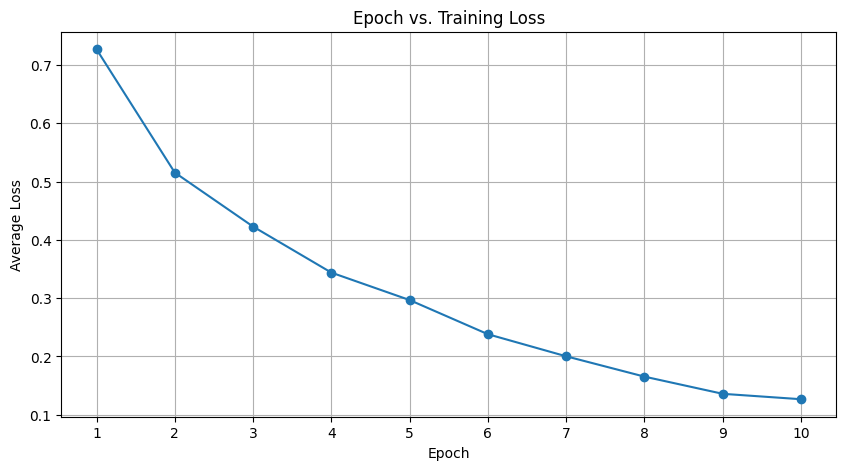

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), epoch_losses, marker='o', linestyle='-')
plt.title('Epoch vs. Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.grid(True)
plt.show()

In [7]:
correct = 0.0
test_loss = 0.0
size = len(validation_loader.dataset)  # numarul total de exemple din setul de validare
model.to(device)
model.eval()
predictions = []
with torch.no_grad():
    for image_batch, labels_batch in validation_loader:
        image_batch = image_batch.to(device)
        labels_batch = labels_batch.to(device)
        image_batch = image_batch.permute(0, 3, 1, 2)

        pred = model(
            image_batch
        )  # procesam imaginile folosind reteaua antrenata anterior

        predictions.append(pred)

        test_loss += loss_fn(pred, labels_batch).item()

        correct += (
            (pred.argmax(1) == labels_batch).type(torch.float).sum().item()
        )  # numaram cate exemple sunt corect clasificate

correct /= size
test_loss /= size
print(f"Accuracy: {(100*correct):>0.1f}%, Loss: {test_loss:>8f} \n")

predictions = torch.cat(predictions, dim=0)
predictions = predictions.argmax(dim=1).cpu().numpy()
print(predictions.shape)
        

Accuracy: 81.0%, Loss: 0.009528 

(1250,)


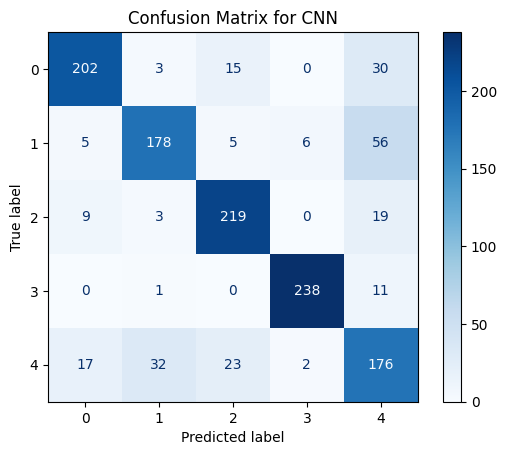

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(validation_dataset.labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for CNN")
plt.show()

In [ ]:
correct = 0.0
test_loss = 0.0
size = len(validation_loader.dataset)  # numarul total de exemple din setul de validare
model.to(device)
model.eval()
predictions = []
with torch.no_grad():
    for image_batch, labels_batch in test_loader:
        image_batch = image_batch.to(device)
        image_batch = image_batch.permute(0, 3, 1, 2) 
        pred = model(
            image_batch
        )  # procesam imaginile folosind reteaua antrenata anterior
        predictions.append(pred)
predictions = torch.cat(predictions, dim=0)
predictions = (
    predictions.argmax(dim=1).cpu().numpy()
print(predictions)

In [ ]:
from data_utils import save_predictions_to_csv

ids = test_dataset.ids

save_predictions_to_csv(predictions, ids, "predictions2.csv")